In [1]:
# ----------------------------------------------------------------------
# CELL 1: IMPORTS
# ----------------------------------------------------------------------

import os
import cv2
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display, Image
import ipywidgets as widgets
from ipywidgets import VBox, HBox
import logging

# NEW: YOLO for object detection
from ultralytics import YOLO

# ----------------------------------------------------------------------
# SETUP LOGGING
# ----------------------------------------------------------------------

# Base path for logs (we’ll define BASE_DIR later in Cell 2)
LOG_DIR = r"D:\project\Localens_experiment\logs"
os.makedirs(LOG_DIR, exist_ok=True)
LOG_FILE = os.path.join(LOG_DIR, "localens.log")

logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)

print("All essential libraries loaded and logging configured.")


All essential libraries loaded and logging configured.


In [2]:
# ----------------------------------------------------------------------
# CELL 2: PATHS & CONFIGURATION (UPDATED)
# ----------------------------------------------------------------------

# Base project directory
BASE_DIR = r"D:\project\Localens_experiment"

# Dataset directory (contains multiple subfolders of images)
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

# Database file (stores image metadata)
CSV_PATH = os.path.join(BASE_DIR, "image_data.csv")

# JSON file (stores per-folder last scan times to avoid reprocessing)
TIMESTAMPS_FILE = os.path.join(BASE_DIR, "last_scan_times.json")

# Model directory and YOLO model path
MODELS_DIR = os.path.join(BASE_DIR, "models")
MODEL_PATH = os.path.join(MODELS_DIR, "yolov8s.pt")

# Ensure required directories exist
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Database columns
DB_COLUMNS = ['path', 'folder', 'timestamp', 'R', 'G', 'B', 'objects']

# ----------------------------------------------------------------------
# LOAD YOLO MODEL (once at startup)
# ----------------------------------------------------------------------
try:
    from ultralytics import YOLO
    if os.path.exists(MODEL_PATH):
        model = YOLO(MODEL_PATH)
        print(f"✅ YOLO model loaded from: {MODEL_PATH}")
    else:
        print(f"⚠️ Model not found at {MODEL_PATH}. Downloading yolov8s.pt ...")
        model = YOLO('yolov8s.pt')  # auto-download if not found
except Exception as e:
    print("❌ Failed to load YOLO model:", e)
    model = None

# ----------------------------------------------------------------------
# LOGGING BASIC INFO
# ----------------------------------------------------------------------
import logging

logging.info("------ Localens Initialization ------")
logging.info(f"Base Directory: {BASE_DIR}")
logging.info(f"Dataset Directory: {DATASET_DIR}")
logging.info(f"Database File: {CSV_PATH}")
logging.info(f"Timestamps File: {TIMESTAMPS_FILE}")
logging.info(f"Model Path: {MODEL_PATH}")
logging.info("YOLO model loaded successfully." if model else "YOLO model not loaded.")

print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"Database File: {CSV_PATH}")
print(f"Timestamps File: {TIMESTAMPS_FILE}")


✅ YOLO model loaded from: D:\project\Localens_experiment\models\yolov8s.pt
Base Directory: D:\project\Localens_experiment
Dataset Directory: D:\project\Localens_experiment\dataset
Database File: D:\project\Localens_experiment\image_data.csv
Timestamps File: D:\project\Localens_experiment\last_scan_times.json


In [3]:
# ----------------------------------------------------------------------
# CELL 3: DATABASE INITIALIZATION (UPDATED)
# ----------------------------------------------------------------------

def initialize_database():
    """
    Creates the CSV and JSON files with headers if they don't exist.
    Logs creation events.
    """
    try:
        if not os.path.exists(CSV_PATH):
            print(f"Creating new database file: {CSV_PATH}")
            df = pd.DataFrame(columns=DB_COLUMNS)
            df.to_csv(CSV_PATH, index=False)
            logging.info(f"Created new database CSV: {CSV_PATH}")
        else:
            logging.info(f"Database CSV already exists: {CSV_PATH}")

        if not os.path.exists(TIMESTAMPS_FILE):
            print(f"Creating new timestamps file: {TIMESTAMPS_FILE}")
            with open(TIMESTAMPS_FILE, 'w') as f:
                json.dump({}, f)
            logging.info(f"Created new timestamps JSON: {TIMESTAMPS_FILE}")
        else:
            logging.info(f"Timestamps JSON already exists: {TIMESTAMPS_FILE}")

    except Exception as e:
        logging.error(f"Error initializing database: {e}")
        print("❌ Error initializing database:", e)


def load_database():
    """Loads the database CSV safely."""
    try:
        df = pd.read_csv(CSV_PATH)
        # Guarantee correct columns even if file got modified manually
        for col in DB_COLUMNS:
            if col not in df.columns:
                df[col] = np.nan
        df = df[DB_COLUMNS]
        return df
    except pd.errors.EmptyDataError:
        logging.warning("Database CSV was empty — returning blank DataFrame.")
        return pd.DataFrame(columns=DB_COLUMNS)
    except Exception as e:
        logging.error(f"Failed to load database: {e}")
        print("⚠️ Failed to load database, returning blank DataFrame.")
        return pd.DataFrame(columns=DB_COLUMNS)


def save_database(df):
    """Saves the DataFrame back to the database CSV."""
    try:
        df.to_csv(CSV_PATH, index=False)
        logging.info(f"Database saved successfully with {len(df)} entries.")
    except Exception as e:
        logging.error(f"Failed to save database: {e}")
        print("❌ Failed to save database:", e)


def load_scan_times():
    """Loads the per-folder timestamp dictionary from the JSON file."""
    try:
        with open(TIMESTAMPS_FILE, 'r') as f:
            return json.load(f)
    except json.JSONDecodeError:
        logging.warning("Timestamps JSON corrupt or empty — returning empty dict.")
        return {}
    except Exception as e:
        logging.error(f"Failed to load scan times: {e}")
        return {}


def save_scan_times(times_dict):
    """Saves the timestamp dictionary back to the JSON file."""
    try:
        with open(TIMESTAMPS_FILE, 'w') as f:
            json.dump(times_dict, f, indent=2)
        logging.info("Timestamps JSON saved successfully.")
    except Exception as e:
        logging.error(f"Failed to save scan times: {e}")
        print("❌ Failed to save scan times:", e)


# --- Run the initialization ---
initialize_database()
print("✅ Database and helper functions are ready.")


✅ Database and helper functions are ready.


In [4]:
# ----------------------------------------------------------------------
# CELL 4: COLOR LOGIC & IMAGE PROCESSING (UPDATED)
# ----------------------------------------------------------------------

def classify_color(h, s, v):
    """Classify color name from HSV values."""
    h = int(h)
    s = int(s)
    v = int(v)
    h_deg = h * 2

    if v < 40 and s < 60:
        return "black"
    if v > 230 and s < 30:
        return "white"
    if v > 180 and s < 40:
        return "gray"
    if 15 <= h_deg <= 35:
        if v < 120:
            return "brown"
        elif 120 <= v <= 200:
            return "orange"
        else:
            return "yellow"
    if 35 < h_deg <= 85:
        return "green"
    if 85 < h_deg <= 150:
        return "cyan"
    if 150 < h_deg <= 260:
        return "blue"
    if 260 < h_deg <= 320:
        return "purple"
    if 320 < h_deg <= 345:
        return "pink"
    if h_deg < 15 or h_deg > 345:
        return "red"
    return "unknown"


def extract_dominant_color_lab(image, k=5):
    """Find the dominant color in LAB space and return HSV + label."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape(-1, 3)

    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)

    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_cluster = unique[np.argmax(counts)]
    dominant_color = kmeans.cluster_centers_[dominant_cluster]

    lab_color = np.uint8([[dominant_color]])
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    hsv_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]

    h, s, v = hsv_color
    label = classify_color(h, s, v)

    return h, s, v, label


def detect_document_shape(image):
    """
    Detects if the image contains a document-like rectangular shape.
    Returns True if a clear 4-corner contour is found.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)

    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        area = cv2.contourArea(contour)
        if len(approx) == 4 and area > 5000:
            return True
    return False


def process_image(image_path):
    """
    Process an image to extract color, detect objects, and identify document shapes.
    Returns a dictionary matching DB_COLUMNS.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            logging.warning(f"Failed to load image: {image_path}")
            return None

        img_resized = cv2.resize(img, (640, 640))  # YOLO standard size for better detection

        # 1️⃣ Color analysis
        h, s, v, color_label = extract_dominant_color_lab(img_resized)
        rgb = cv2.cvtColor(np.uint8([[[h, s, v]]]), cv2.COLOR_HSV2RGB)[0][0]

        # 2️⃣ Object detection using YOLO
        results = model.predict(source=img_resized, conf=0.25, verbose=False)
        detected_classes = []
        if len(results) > 0 and results[0].boxes is not None:
            for cls_id in results[0].boxes.cls.cpu().numpy():
                cls_name = results[0].names[int(cls_id)]
                detected_classes.append(cls_name)

        # Count each detected object
        object_counts = {}
        for cls in detected_classes:
            object_counts[cls] = object_counts.get(cls, 0) + 1

        # 3️⃣ Detect document shape manually
        if detect_document_shape(img_resized):
            object_counts["document"] = object_counts.get("document", 0) + 1

        # 4️⃣ Determine dominant object (by count, fallback = None)
        dominant_object = None
        if object_counts:
            dominant_object = max(object_counts, key=object_counts.get)

        # 5️⃣ Create the objects JSON-like structure
        objects_info = {
            "dominant": dominant_object,
            "counts": object_counts
        }

        # 6️⃣ Get file modification time
        file_mod_time = os.path.getmtime(image_path)

        # 7️⃣ Return record
        return {
            "path": os.path.normpath(image_path),
            "folder": os.path.normpath(os.path.dirname(image_path)),
            "timestamp": file_mod_time,
            "R": int(rgb[0]),
            "G": int(rgb[1]),
            "B": int(rgb[2]),
            "objects": json.dumps(objects_info)  # store as JSON string in CSV
        }

    except Exception as e:
        logging.error(f"Error processing image {image_path}: {e}")
        return None


print("✅ Image processing functions (color + YOLO + document detection) ready.")


✅ Image processing functions (color + YOLO + document detection) ready.


In [5]:
# ----------------------------------------------------------------------
# CELL 5: SCAN FOR NEW IMAGES (UPDATED)
# ----------------------------------------------------------------------

def scan_for_new_images():
    """
    Scans DATASET_DIR, compares against last scan times,
    processes only new or updated images, and updates the database.
    """
    print("🔍 Running automatic scan for new or updated images...")
    logging.info("Started automatic scan for new/updated images...")

    # 1️⃣ Load current state
    df = load_database()
    scan_times = load_scan_times()

    paths_in_db = set(df['path'])
    new_records = []
    updated_records = []

    new_max_times = scan_times.copy()

    # 2️⃣ Walk through all folders
    for dirpath, _, filenames in os.walk(DATASET_DIR):

        current_folder = os.path.normpath(dirpath)
        last_scan = scan_times.get(current_folder, 0)
        current_max_time_in_folder = last_scan

        for fname in tqdm(filenames, desc=f"Scanning {os.path.basename(current_folder)}"):
            filepath = os.path.normpath(os.path.join(current_folder, fname))

            # Skip non-image files quickly
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            try:
                file_time = os.path.getmtime(filepath)
            except FileNotFoundError:
                continue  # File deleted mid-scan

            # --- Decide whether to process this file ---
            is_new = filepath not in paths_in_db
            is_updated = (filepath in paths_in_db) and (file_time > last_scan)

            if is_new or is_updated:
                result = process_image(filepath)
                if result:
                    if is_new:
                        new_records.append(result)
                    else:
                        updated_records.append(result)
                else:
                    logging.warning(f"Skipped invalid image: {filepath}")

            # Track the newest timestamp
            if file_time > current_max_time_in_folder:
                current_max_time_in_folder = file_time

        # Update per-folder timestamp
        if current_max_time_in_folder > last_scan:
            new_max_times[current_folder] = current_max_time_in_folder

    # 3️⃣ Merge results back into the database
    if new_records or updated_records:
        total_new = len(new_records)
        total_updated = len(updated_records)
        print(f"\n✅ Found {total_new} new and {total_updated} updated images.")
        logging.info(f"Found {total_new} new and {total_updated} updated images.")

        if new_records:
            new_df = pd.DataFrame(new_records, columns=DB_COLUMNS)
            df = pd.concat([df, new_df], ignore_index=True)

        # Overwrite updated images
        if updated_records:
            for record in updated_records:
                df.loc[df['path'] == record['path'], :] = pd.Series(record)

        save_database(df)
        save_scan_times(new_max_times)
        print("📀 Database updated successfully.")
    else:
        print("\nNo new or updated images found.")
        save_scan_times(new_max_times)

    logging.info("Automatic scan complete.")


# --- Run the automatic scan ---
scan_for_new_images()


🔍 Running automatic scan for new or updated images...


Scanning dataset: 0it [00:00, ?it/s]
Scanning unlabeled: 100%|██████████████████████████| 87/87 [00:00<?, ?it/s]


No new or updated images found.


In [7]:
# ----------------------------------------------------------------------
# CELL 6: CORE - MANUAL "DELETED IMAGE" SCAN (UPDATED V2)
# ----------------------------------------------------------------------

def scan_for_deleted_images():
    """
    Loads the database, checks if every file path still exists,
    and removes records for deleted files.
    Also cleans deleted folders from the timestamps JSON.
    """
    print("🧹 Running MANUAL scan for deleted images and folders...")
    logging.info("Started manual scan for deleted images and folders...")

    # --- 1️⃣ CLEAN THE IMAGE CSV (image_data.csv) ---
    df = load_database()
    if df.empty:
        print("Database is empty. Nothing to clean.")
        logging.info("Database is empty — nothing to clean.")
    else:
        initial_count = len(df)
        print(f"Checking {initial_count} image records...")
        exists_mask = df['path'].apply(os.path.exists)
        df_clean = df[exists_mask]
        df_deleted = df[~exists_mask]

        deleted_count = len(df_deleted)
        if deleted_count > 0:
            print(f"🗑 Found {deleted_count} deleted images. Removing from CSV...")
            logging.info(f"Removing {deleted_count} deleted image records from database.")
            save_database(df_clean)
            print(f"✅ Removed {deleted_count} records. {len(df_clean)} remain.")
        else:
            print("No deleted images found in CSV.")
            logging.info("No deleted images found in CSV.")

    print("\n" + "-"*40 + "\n")

    # --- 2️⃣ CLEAN THE FOLDER JSON (last_scan_times.json) ---
    print("Checking for deleted folders in timestamps file...")
    scan_times = load_scan_times()

    if not scan_times:
        print("Timestamps file is empty. Nothing to clean.")
        logging.info("Timestamps file empty — nothing to clean.")
        return

    clean_scan_times = {}
    deleted_folder_count = 0

    for folder_path, timestamp in scan_times.items():
        if os.path.exists(folder_path):
            clean_scan_times[folder_path] = timestamp
        else:
            deleted_folder_count += 1

    if deleted_folder_count > 0:
        save_scan_times(clean_scan_times)
        print(f"🗑 Removed {deleted_folder_count} deleted folders from timestamps JSON.")
        logging.info(f"Removed {deleted_folder_count} deleted folders from timestamps JSON.")
    else:
        print("No deleted folders found in timestamps JSON.")
        logging.info("No deleted folders found in timestamps JSON.")

    print("\n✅ Manual scan complete.")
    logging.info("Manual delete scan complete.\n")


# --- Run immediately ---
scan_for_deleted_images()

print("\nManual delete scan function ready.")
print("To run again later, call scan_for_deleted_images().")


Running MANUAL scan for deleted images...
Checking 321 image records...
No deleted images found in CSV.

------------------------------

Checking for deleted folders in timestamps file...
No deleted folders found in timestamps JSON.

Manual scan complete.

Manual delete scan function is ready.
To run it again, type 'scan_for_deleted_images()' in a new cell and run it.


🔍 Localens Smart Search (type 'exit' anytime to stop)


----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  red
🧠 Enter object name (e.g., person, dog, car) or leave blank:  


❌ No matches found.

----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  black
🧠 Enter object name (e.g., person, dog, car) or leave blank:  



✅ Found 122 matching images (showing newest 10):

🖼️ D:\project\Localens_experiment\dataset\extra\salad-g8aa52b764_640.jpg | Dist: 64 | Date: 2025-10-31 01:25


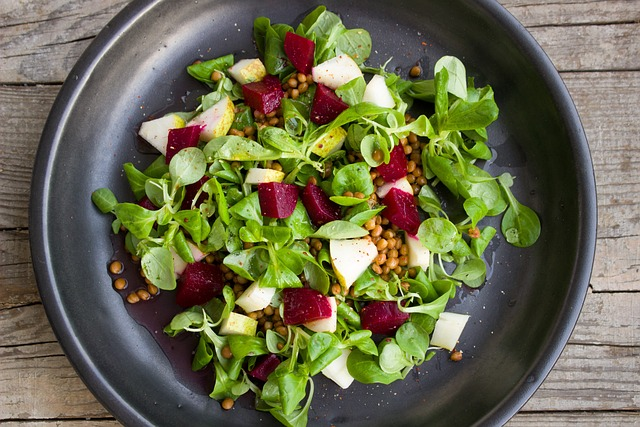


🖼️ D:\project\Localens_experiment\dataset\extra\sad-g31db419ca_640.jpg | Dist: 57 | Date: 2025-10-31 01:25


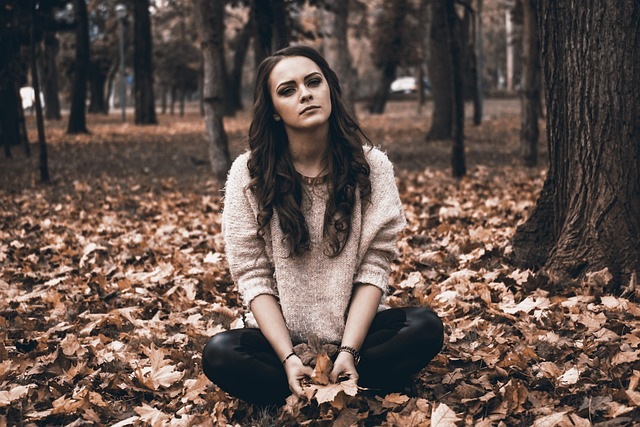


🖼️ D:\project\Localens_experiment\dataset\extra\man-g80cf5109d_640.jpg | Dist: 22 | Date: 2025-10-31 01:25


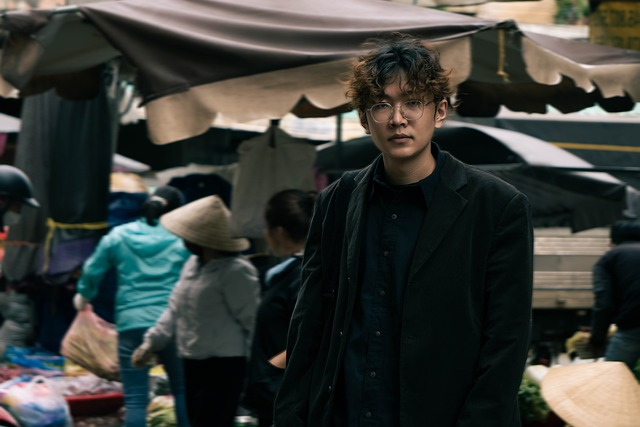


🖼️ D:\project\Localens_experiment\dataset\extra\hamburger-gafdf3eadc_640.jpg | Dist: 37 | Date: 2025-10-31 01:25


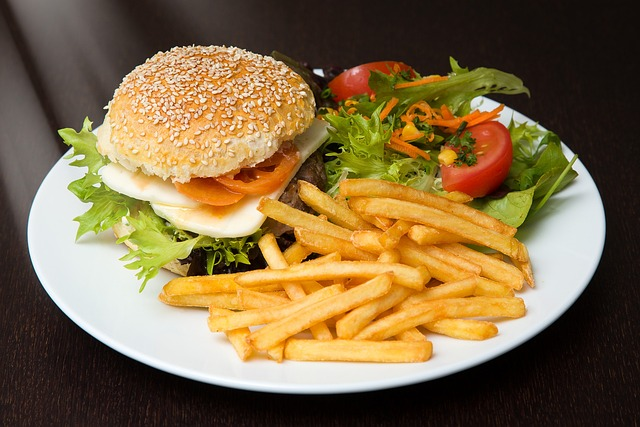


🖼️ D:\project\Localens_experiment\dataset\extra\girl-gb9f87fafe_640.jpg | Dist: 10 | Date: 2025-10-31 01:25


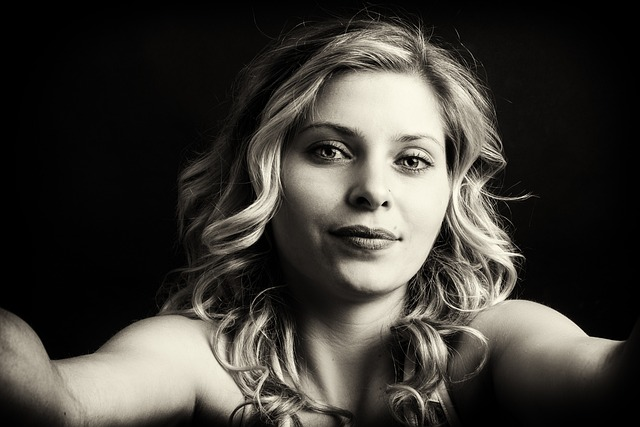


🖼️ D:\project\Localens_experiment\dataset\extra\father-g7328a944c_640.jpg | Dist: 29 | Date: 2025-10-31 01:25


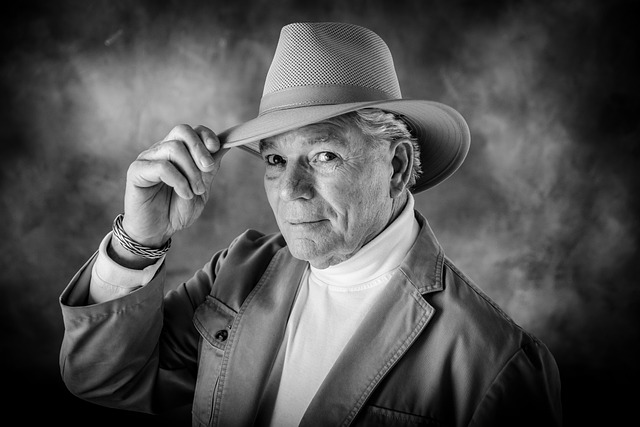


🖼️ D:\project\Localens_experiment\dataset\extra\family-gc23518eae_640.jpg | Dist: 28 | Date: 2025-10-31 01:25


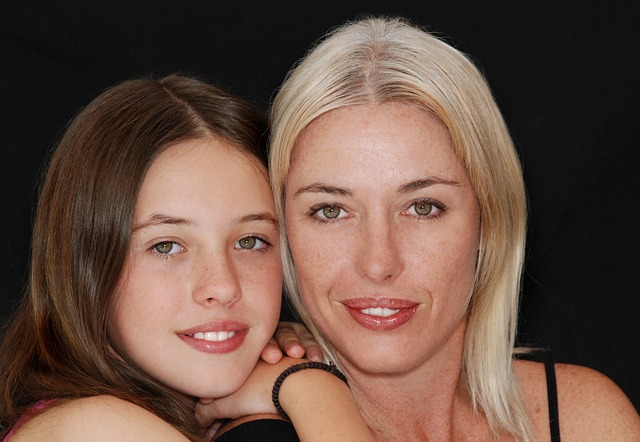


🖼️ D:\project\Localens_experiment\dataset\extra\children-g13a48a038_640.jpg | Dist: 48 | Date: 2025-10-31 01:25


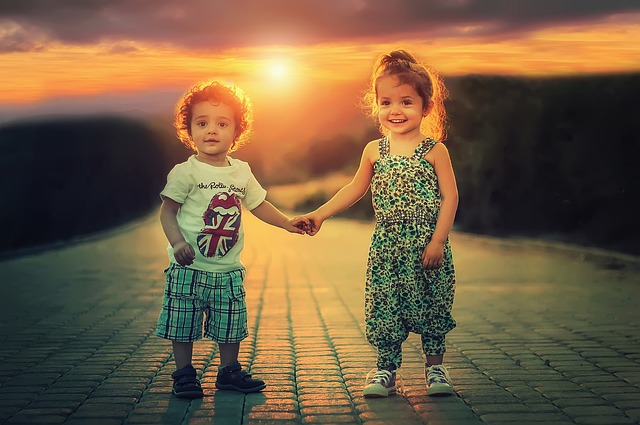


🖼️ D:\project\Localens_experiment\dataset\extra\dog-g904e7432d_640.jpg | Dist: 47 | Date: 2025-10-31 01:25


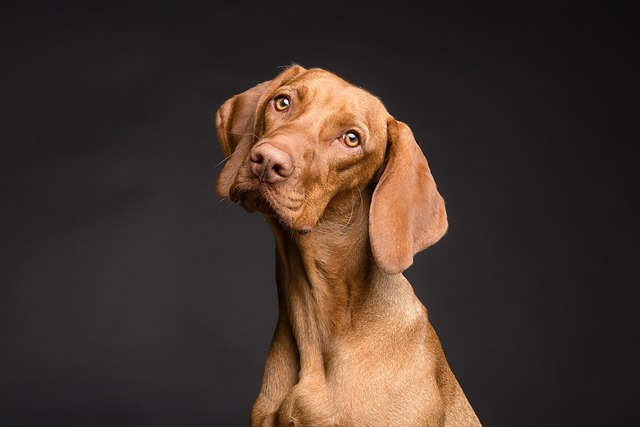


🖼️ D:\project\Localens_experiment\dataset\extra\elderly-woman-gf7899b581_640.jpg | Dist: 49 | Date: 2025-10-31 01:25


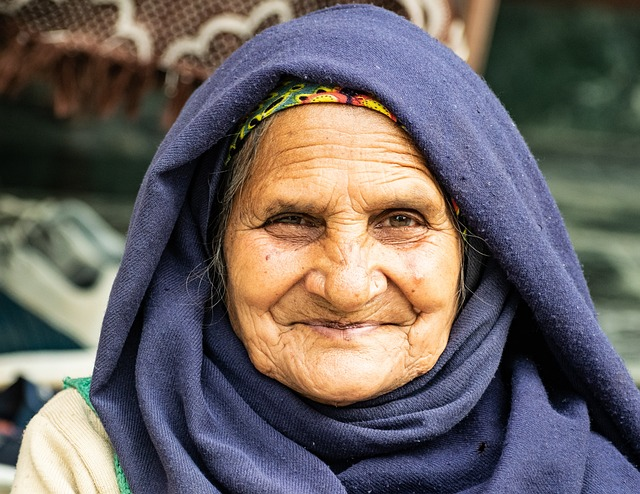


----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  pink
🧠 Enter object name (e.g., person, dog, car) or leave blank:  



✅ Found 64 matching images (showing newest 10):

🖼️ D:\project\Localens_experiment\dataset\extra\women-girl-gf81cdab46_640.jpg | Dist: 58 | Date: 2025-10-31 01:25


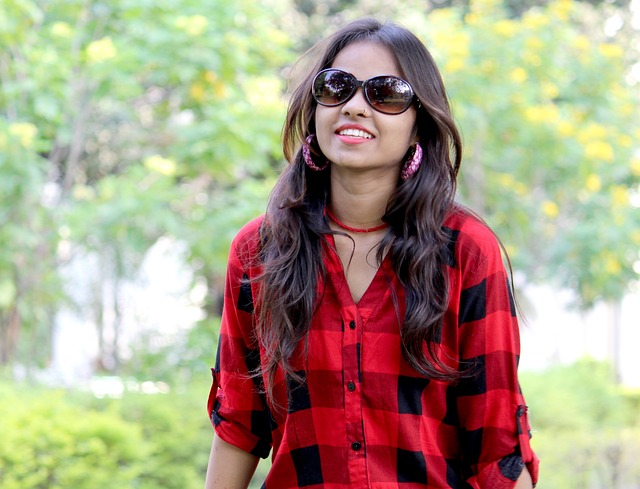


🖼️ D:\project\Localens_experiment\dataset\extra\woman-g40964425a_640.jpg | Dist: 51 | Date: 2025-10-31 01:25


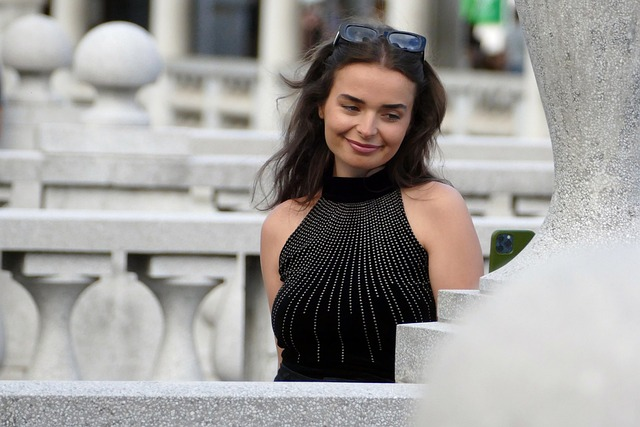


🖼️ D:\project\Localens_experiment\dataset\extra\sushi-g47b8ca32e_640.jpg | Dist: 46 | Date: 2025-10-31 01:25


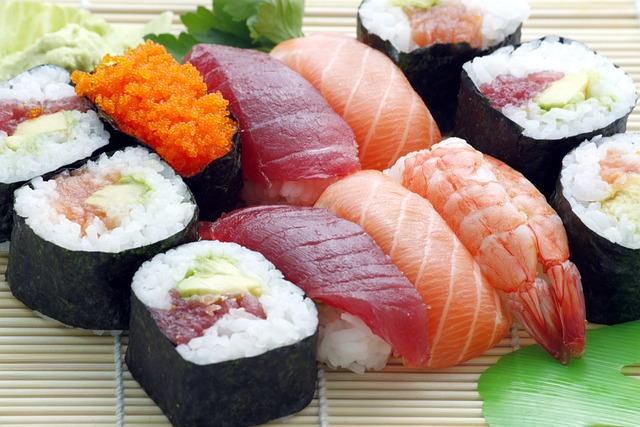


🖼️ D:\project\Localens_experiment\dataset\extra\sushi-g108a16441_640.jpg | Dist: 49 | Date: 2025-10-31 01:25


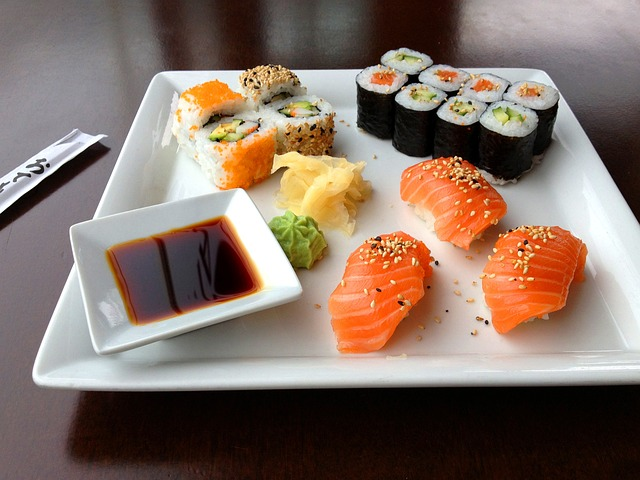


🖼️ D:\project\Localens_experiment\dataset\extra\sibling-g1003a623b_640.jpg | Dist: 73 | Date: 2025-10-31 01:25


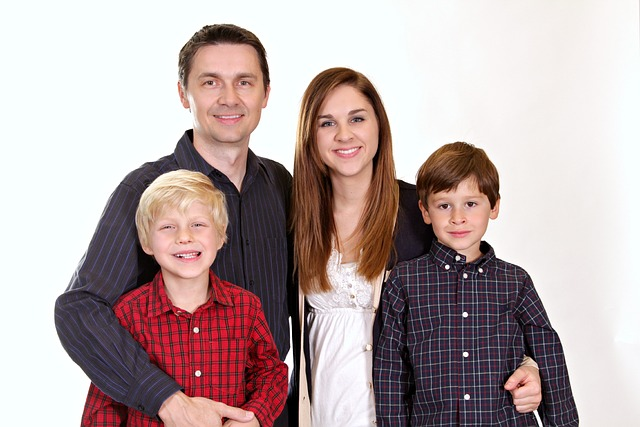


🖼️ D:\project\Localens_experiment\dataset\extra\sad-g7e6ada8a4_640.jpg | Dist: 64 | Date: 2025-10-31 01:25


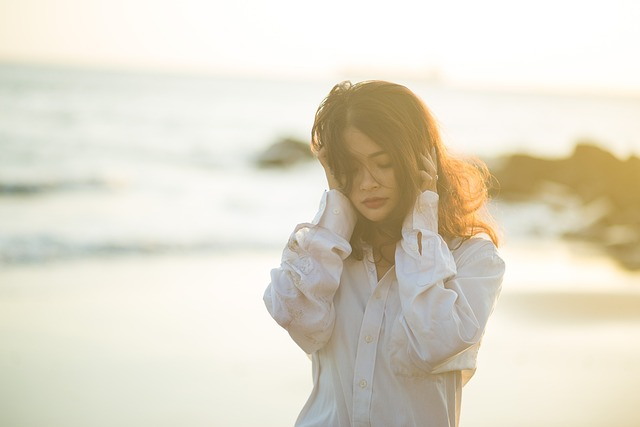


🖼️ D:\project\Localens_experiment\dataset\extra\puppy-ge9d742e37_640.jpg | Dist: 54 | Date: 2025-10-31 01:25


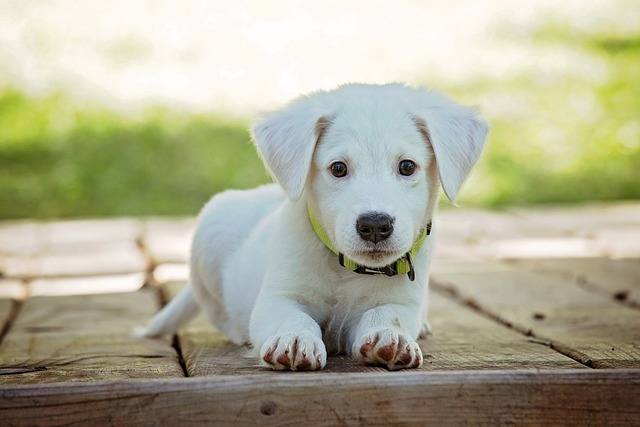


🖼️ D:\project\Localens_experiment\dataset\extra\puppy-g7bfbbf1d9_640.jpg | Dist: 42 | Date: 2025-10-31 01:25


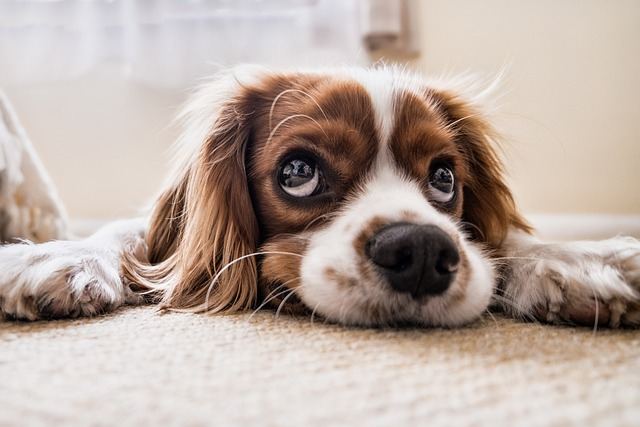


🖼️ D:\project\Localens_experiment\dataset\extra\person-gda5ec2e25_640.jpg | Dist: 59 | Date: 2025-10-31 01:25


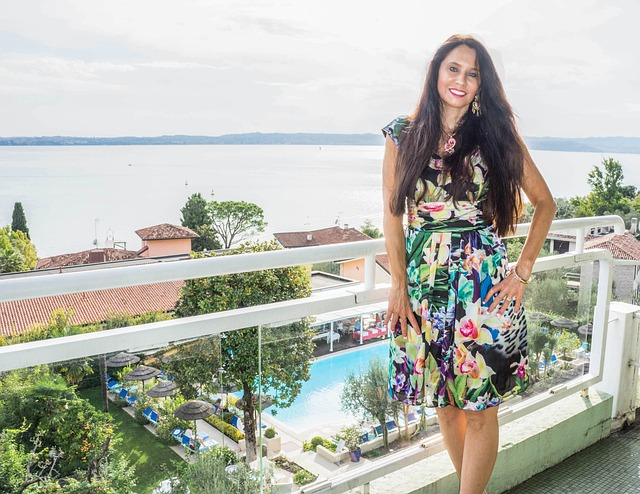


🖼️ D:\project\Localens_experiment\dataset\extra\pasta-ge05c4d3a5_640.jpg | Dist: 60 | Date: 2025-10-31 01:25


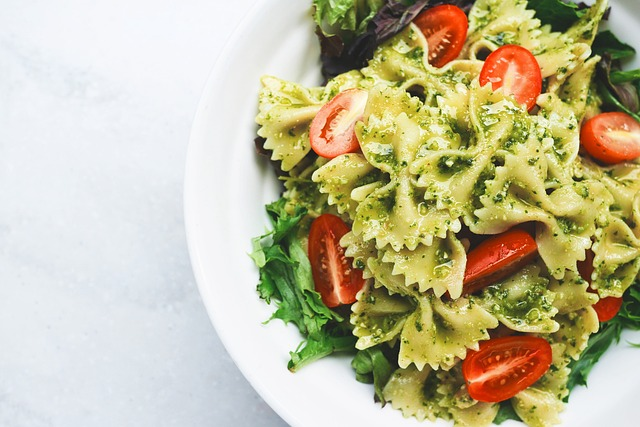


----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  cat
🧠 Enter object name (e.g., person, dog, car) or leave blank:  cat


❌ Unknown color name: 'cat'. Skipping color filter.
❌ No matches found.

----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  
🧠 Enter object name (e.g., person, dog, car) or leave blank:  cat



✅ Found 8 matching images (showing newest 10):

🖼️ D:\project\Localens_experiment\dataset\extra\kitten-gfa0ebce93_640.jpg | Date: 2025-10-31 01:25


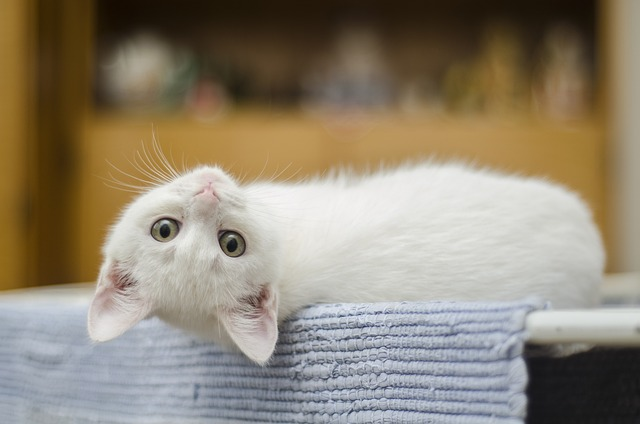


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g0052cc4e9_640.jpg | Date: 2025-10-31 01:25


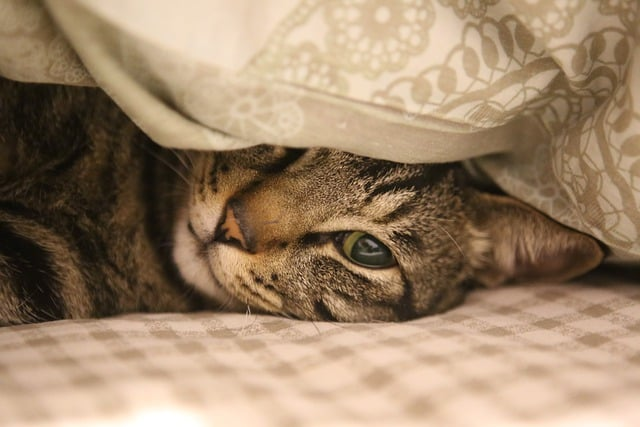


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g0fcd844a4_640.jpg | Date: 2025-10-31 01:25


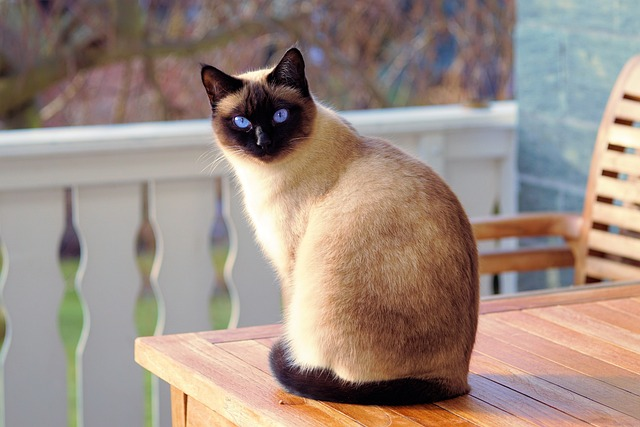


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g11b1f4535_640.jpg | Date: 2025-10-31 01:25


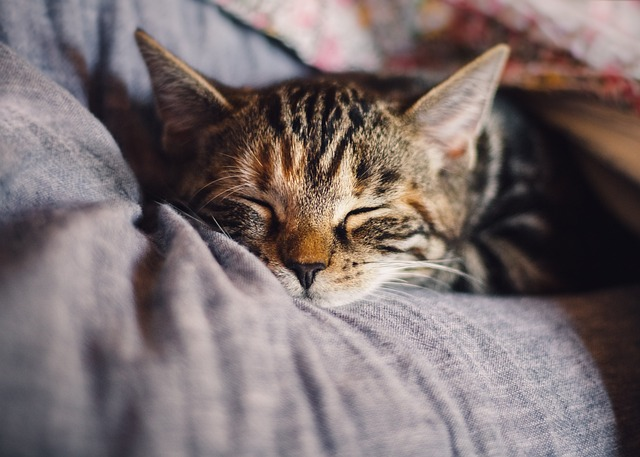


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g4ae5d18aa_640.jpg | Date: 2025-10-31 01:25


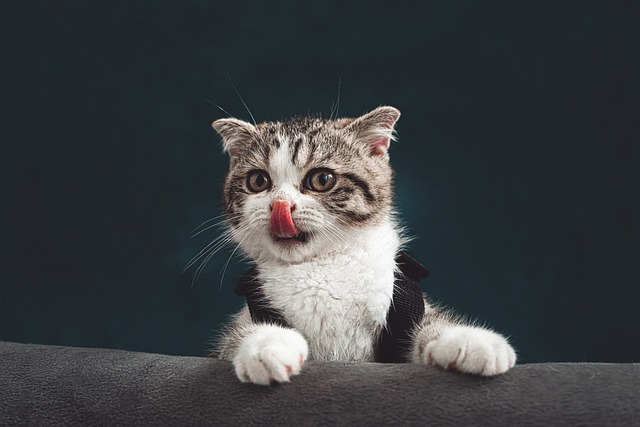


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g4fe5d8c20_640.jpg | Date: 2025-10-31 01:25


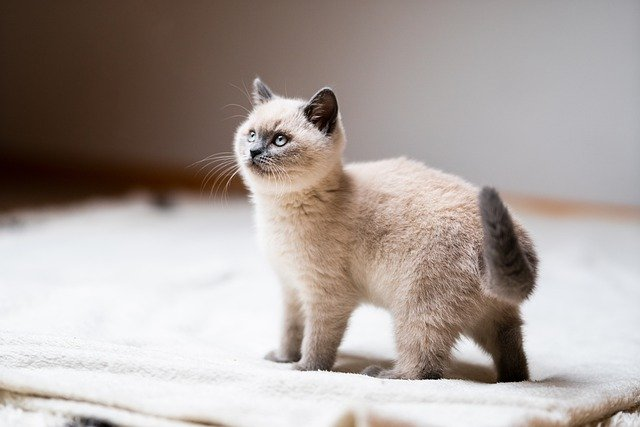


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g6052b543b_640.jpg | Date: 2025-10-31 01:25


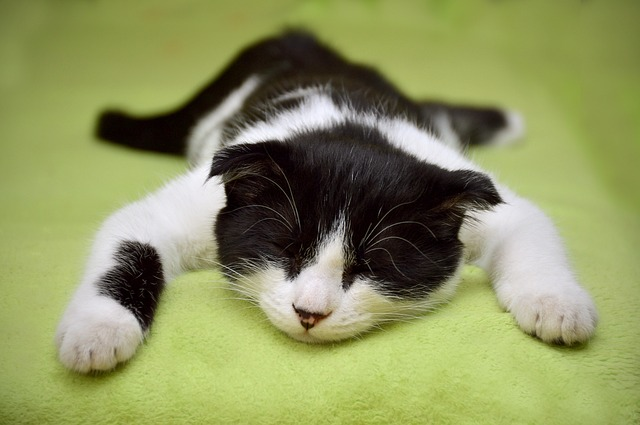


🖼️ D:\project\Localens_experiment\dataset\extra\cat-ga3a48da6e_640.jpg | Date: 2025-10-31 01:25


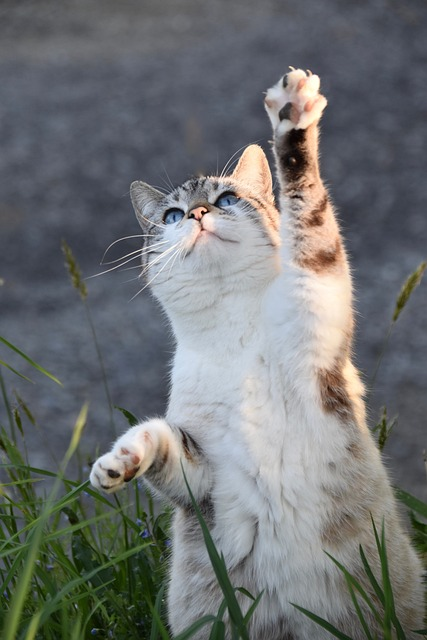


----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  
🧠 Enter object name (e.g., person, dog, car) or leave blank:  dog



✅ Found 13 matching images (showing newest 10):

🖼️ D:\project\Localens_experiment\dataset\extra\terrier-g5cb29fa82_640.jpg | Date: 2025-10-31 01:25


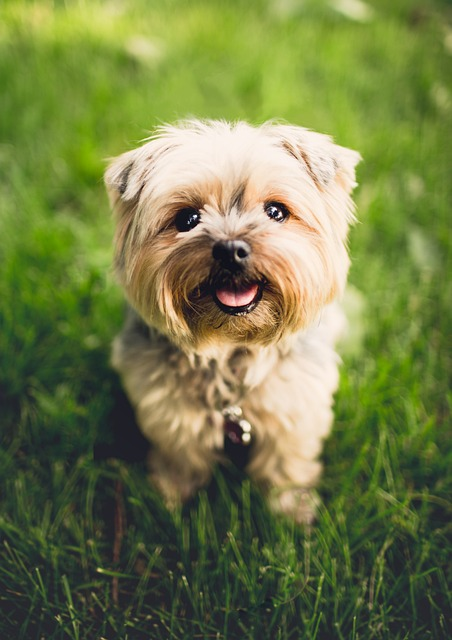


🖼️ D:\project\Localens_experiment\dataset\extra\puppy-ge9d742e37_640.jpg | Date: 2025-10-31 01:25


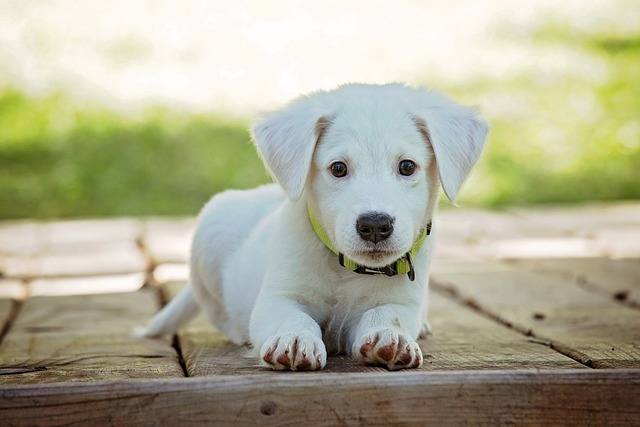


🖼️ D:\project\Localens_experiment\dataset\extra\puppy-g7bfbbf1d9_640.jpg | Date: 2025-10-31 01:25


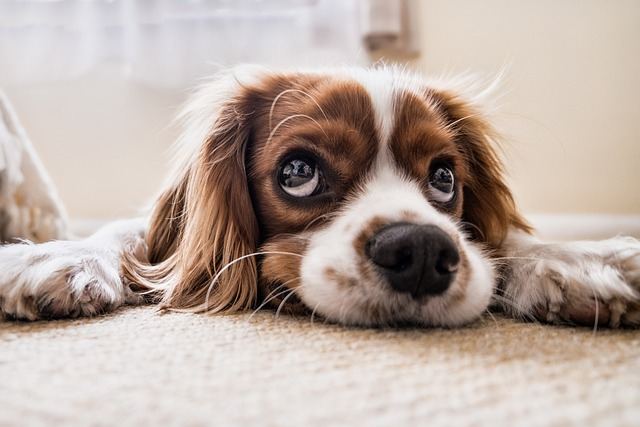


🖼️ D:\project\Localens_experiment\dataset\extra\puppy-g0235e261e_640.jpg | Date: 2025-10-31 01:25


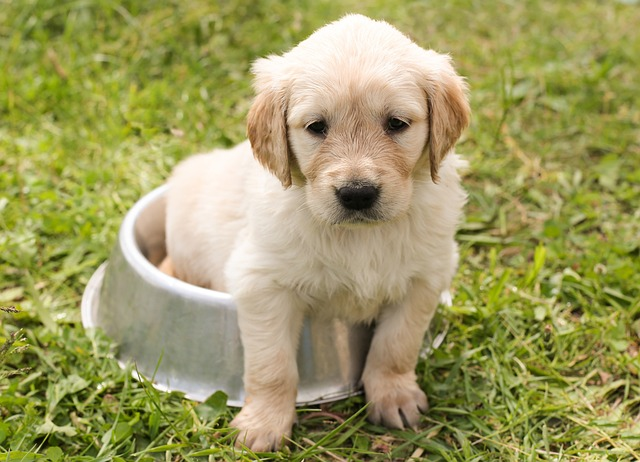


🖼️ D:\project\Localens_experiment\dataset\extra\dog-g0973e56d5_640.jpg | Date: 2025-10-31 01:25


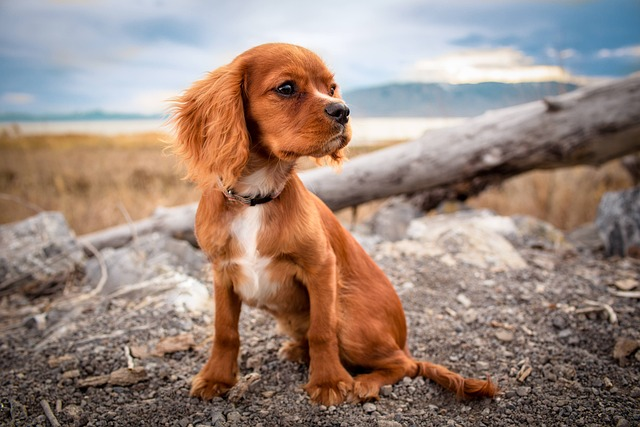


🖼️ D:\project\Localens_experiment\dataset\extra\dog-g7dcd325a6_640.jpg | Date: 2025-10-31 01:25


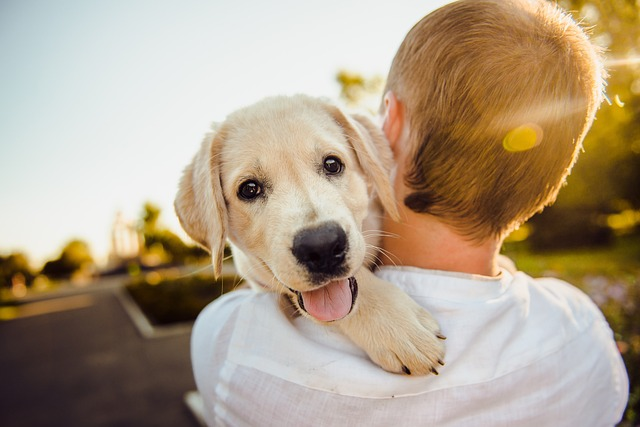


🖼️ D:\project\Localens_experiment\dataset\extra\dog-g904e7432d_640.jpg | Date: 2025-10-31 01:25


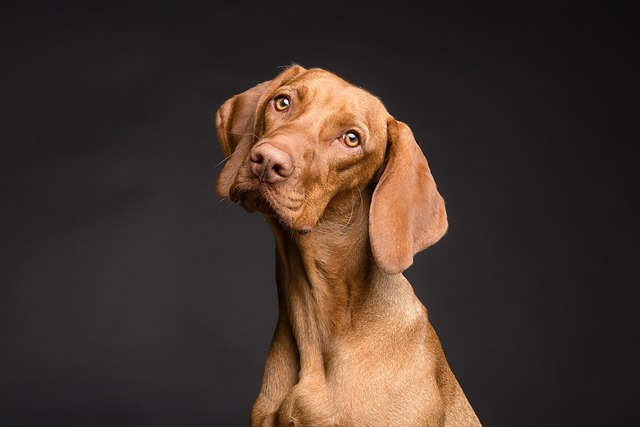


🖼️ D:\project\Localens_experiment\dataset\extra\cat-gf324dae69_640.jpg | Date: 2025-10-31 01:25


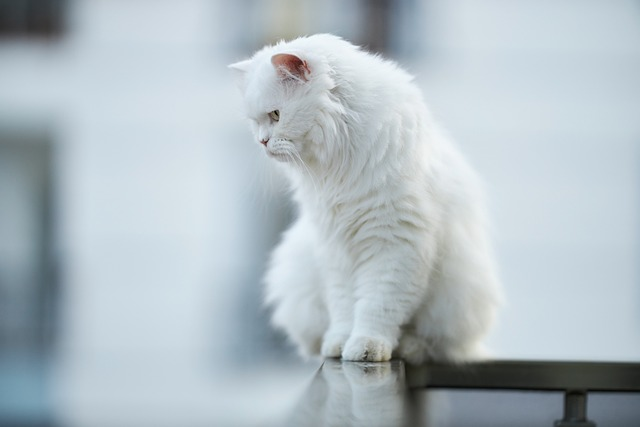


🖼️ D:\project\Localens_experiment\dataset\extra\child-g8f11ee379_640.jpg | Date: 2025-10-31 01:25


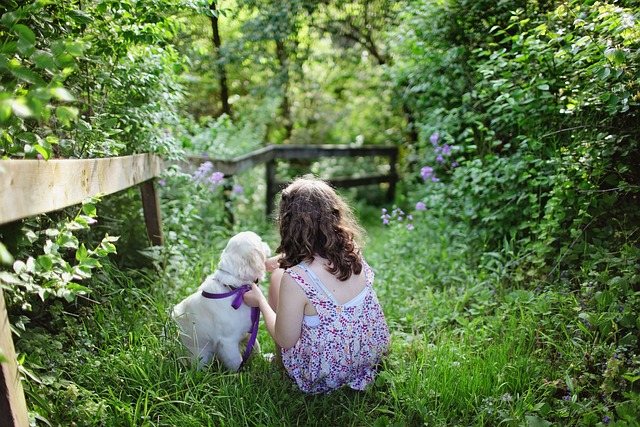


🖼️ D:\project\Localens_experiment\dataset\extra\cat-g4ae5d18aa_640.jpg | Date: 2025-10-31 01:25


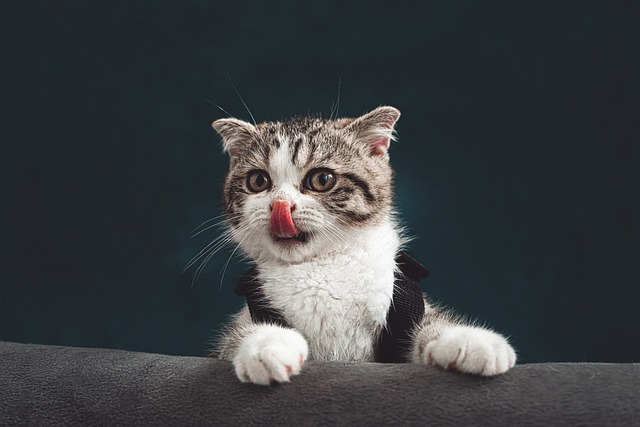


----------------------------------------------------------------------


🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit:  exit


👋 Exiting search loop.


In [7]:
# ----------------------------------------------------------------------
# CELL 7: SMART SEARCH LOOP (COLOR / OBJECT SEARCH)
# ----------------------------------------------------------------------

import json
import webcolors
from datetime import datetime
import numpy as np
from IPython.display import display, Image

print("🔍 Localens Smart Search (type 'exit' anytime to stop)\n")

df = load_database()
if df.empty:
    print("⚠️ Database is empty. Please run the scanning cells first.")
else:
    FIXED_RADIUS = 80  # fixed color tolerance for good similarity balance

    while True:
        print("\n" + "-" * 70)
        color_name = input("🎨 Enter color name (e.g., red, blue, green) or 'exit' to quit: ").strip().lower()
        if color_name == "exit":
            print("👋 Exiting search loop.")
            break

        object_name = input("🧠 Enter object name (e.g., person, dog, car) or leave blank: ").strip().lower()
        if object_name == "exit":
            print("👋 Exiting search loop.")
            break

        if not color_name and not object_name:
            print("⚠️ Please enter at least one (color or object).")
            continue

        # --- COLOR FILTER ---
        if color_name:
            try:
                target_rgb = np.array(webcolors.name_to_rgb(color_name))
                db_rgbs = df[["R", "G", "B"]].values
                distances = np.sqrt(np.sum((db_rgbs - target_rgb) ** 2, axis=1))
                df["dist"] = distances
                df_color = df[df["dist"] <= FIXED_RADIUS]
            except ValueError:
                print(f"❌ Unknown color name: '{color_name}'. Skipping color filter.")
                df_color = df.copy()
                df["dist"] = np.nan
        else:
            df_color = df.copy()
            df["dist"] = np.nan

        # --- OBJECT FILTER ---
        if object_name:
            def has_object(obj_json):
                try:
                    data = json.loads(obj_json)
                    return object_name in data.get("counts", {})
                except Exception:
                    return False
            df_obj = df[df["objects"].apply(has_object)]
        else:
            df_obj = df.copy()

        # --- COMBINE FILTERS (intersection if both given) ---
        results = pd.merge(df_color, df_obj, how="inner")
        results = results.drop_duplicates(subset="path")
        results = results.sort_values(by="timestamp", ascending=False)

        # --- DISPLAY RESULTS ---
        if results.empty:
            print("❌ No matches found.")
        else:
            total = len(results)
            print(f"\n✅ Found {total} matching images (showing newest 10):")
            for i, (_, row) in enumerate(results.iterrows()):
                if i >= 10:
                    break
                date_str = datetime.fromtimestamp(row["timestamp"]).strftime("%Y-%m-%d %H:%M")
                dist_str = f" | Dist: {row['dist']:.0f}" if not np.isnan(row["dist"]) else ""
                print(f"\n🖼️ {row['path']}{dist_str} | Date: {date_str}")
                if os.path.exists(row["path"]):
                    display(Image(filename=row["path"], width=200))
